In [2]:
import json
import logging

from math import sqrt
import numpy as np
from scipy.stats import ttest_1samp 

from pathlib import Path


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

from src.utils.data import *
from src.utils.plots import *
from src.utils.sampling import *
from src.utils.memory_management import *
from src.utils.statistics_utils import *

# Set up logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create a console handler
sh = logging.StreamHandler()
sh.setLevel(logging.INFO)
# Add the handler to the logger
logger.addHandler(sh)

from src.configs.config_parser import PathConfigParser, data_config_file, project_root

# Configs Directory
parser = PathConfigParser(str(data_config_file))
parser.load()

# Data Paths
PROCESSED_DATA_PATH = project_root / parser.get("data_paths", {}).get("processed_data")
GE_PATH = parser.get("data_paths", {}).get("brain_regions_genes_ge")
PROCESSED_DONORS_GE_PATH = PROCESSED_DATA_PATH / GE_PATH

OUTPUT_DATA = project_root / parser.get("data_paths", {}).get("output_data")

# Donors_ids
DONORS_IDS = parser.get("donors_ids")

Loading main dataframe

In [2]:
meta_donor_csv_pth = PROCESSED_DONORS_GE_PATH / Path("meta_donor.csv")
meta_donor_df = load_df_from_csv(meta_donor_csv_pth)
meta_donor_df.head(3)

meta_donor_df["gene_expression_values"]=meta_donor_df["gene_expression_values"].apply(json.loads)
logger.info(meta_donor_df["gene_expression_values"][0][0])

1.58747780630413


 Selecting Samples with sample size >=1024

In [3]:
meta_donor_df_filtered = load_df_from_csv(PROCESSED_DONORS_GE_PATH / Path("meta_donor_filtered.csv"))
meta_donor_df_filtered["gene_expression_values"]=meta_donor_df_filtered["gene_expression_values"].apply(json.loads)
logger.info(meta_donor_df_filtered["gene_expression_values"][0][0])

3.4665720939923


In [6]:
stats_df = load_df_from_csv(OUTPUT_DATA / Path('df_stats.csv'))
stats_df.head(3)

,brain_region,gene_id,sum_expression,effect_size_8,p-value_8,power_8,t_stat_8,effect_size_16,p-value_16,power_16,...,power_256,t_stat_256,effect_size_512,p-value_512,power_512,t_stat_512,effect_size_1024,p-value_1024,power_1024,t_stat_1024
0,4012,2541,7305.189875,0.723958,0.039062,0.579479,31.0,0.170152,0.231873,0.159962,...,0.988638,21436.0,0.179155,8.732317e-07,0.991882,81676.0,0.285270,1.100408e-22,1.000000,354526.0
1,4013,1259,9883.385544,0.576161,0.125000,0.431013,27.0,-0.327191,0.798126,0.001882,...,0.991683,21943.0,0.152272,4.490161e-06,0.963761,80536.0,0.088223,1.216660e-05,0.880289,302356.0
2,4013,2541,12655.801370,0.716566,0.054688,0.572157,30.0,0.205089,0.247711,0.194567,...,0.999900,22748.0,0.324791,3.459548e-14,1.000000,90748.0,0.264883,9.052327e-20,1.000000,347825.0


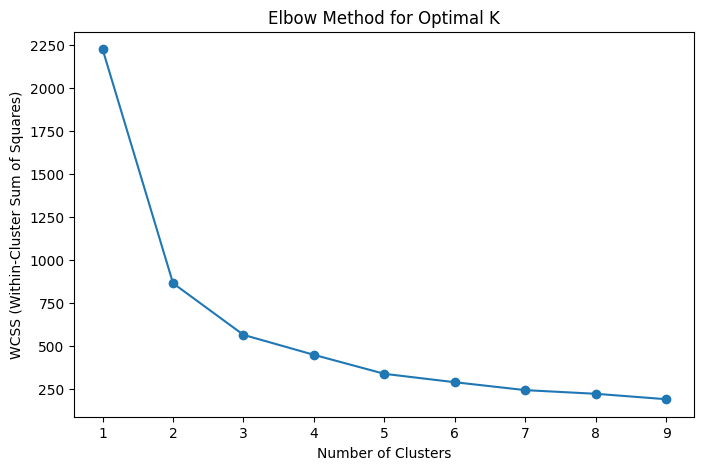

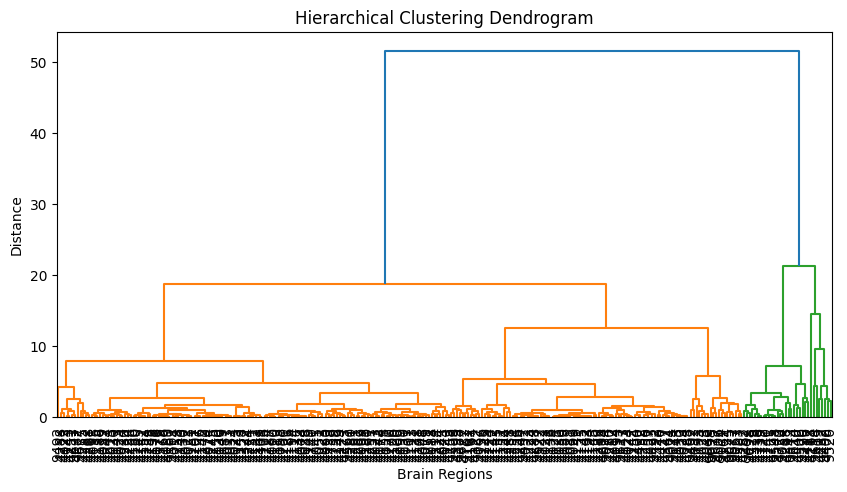

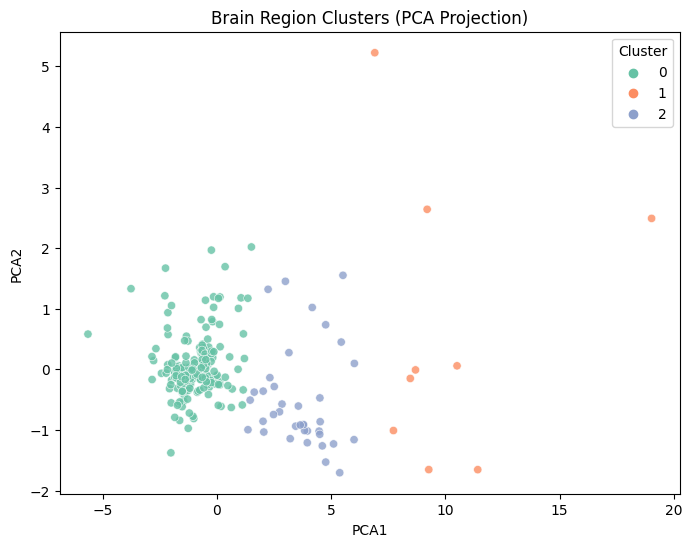

In [15]:
# Load dataset
df =  stats_df.copy() # Replace with your file

# Extract effect size columns dynamically
effect_size_cols = [col for col in df.columns if "effect_size" in col]
effect_size_data = df[effect_size_cols]

# Normalize effect sizes (optional but recommended)
scaler = StandardScaler()
effect_size_scaled = scaler.fit_transform(effect_size_data)
# effect_size_scaled = effect_size_data

# Determine optimal clusters using the Elbow Method
wcss = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(effect_size_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), wcss, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K")
plt.show()

# Choose optimal K (e.g., 3 based on the elbow method)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(effect_size_scaled)

# Hierarchical Clustering (alternative)
linkage_matrix = linkage(effect_size_scaled, method="ward")
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=df["brain_region"].values, leaf_rotation=90, leaf_font_size=10)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Brain Regions")
plt.ylabel("Distance")
plt.show()

# Visualize clusters using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(effect_size_scaled)
df["PCA1"] = pca_result[:, 0]
df["PCA2"] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue=df["Cluster"], palette="Set2", data=df, alpha=0.8)
plt.title("Brain Region Clusters (PCA Projection)")
plt.show()


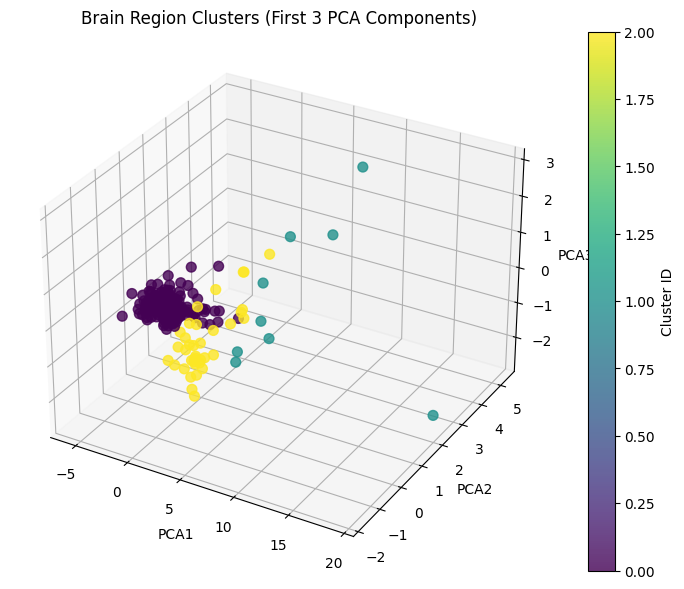

In [16]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Apply PCA to reduce dimensions to 3
pca = PCA(n_components=3)
pca_result = pca.fit_transform(effect_size_scaled)

# Add PCA components to DataFrame
df["PCA1"] = pca_result[:, 0]
df["PCA2"] = pca_result[:, 1]
df["PCA3"] = pca_result[:, 2]

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color based on cluster assignment
scatter = ax.scatter(df["PCA1"], df["PCA2"], df["PCA3"], c=df["Cluster"], cmap="viridis", s=50, alpha=0.8)

# Labels and title
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
ax.set_title("Brain Region Clusters (First 3 PCA Components)")

# Color bar
plt.colorbar(scatter, ax=ax, label="Cluster ID")

# Show the plot
plt.show()